# Getting started

This notebook demonstrates a sample workflow for extracting lip shapes from video data, normalizing them, and performing dimensionality reduction on the data set using `imgphon` and the `audiolabel` library from Ron Sprouse.

### Installs

Several installs are required to use the packages in this notebook. The cv2 package can be installed most easily through conda install: "conda install -c menpo cv3." This is somewhat confusingly called "cv3", apparently to indicate its compatibility with python 3.x, even though it is still imported as cv2.

The dlib install instructions can be found at http://www.pyimagesearch.com/2017/03/27/how-to-install-dlib/ . Imutils is easier to install with pip; simply do "pip install imutils".

These installs would simply be included in the notebook, but doing the dlib installs actually takes a substantial amount of time and disk space (~1GB).

In [8]:
from imgphon import helmet 
from imgphon import imgphon as iph # TODO fix issue with detector and predictor
import os, subprocess, glob, re
import numpy as np
import audiolabel
import cv2
import dlib
from imutils.face_utils import FaceAligner
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [x*2 for x in plt.rcParams['figure.figsize']] # double plot window size]

### Required files

Beyond the installs, dlib needs a face training data set in order for the landmark predictor to be instantiated successfully. The 68-point frontal face dataset that is standard for use of dlib's landmark predictor can be found at https://github.com/davisking/dlib-models. (This comes as a .bz2 archive and needs to be uncompressed before use.) For this demo I have stored an uncompressed copy locally in the repo.

In [100]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
aligner = FaceAligner(predictor, desiredFaceWidth = 256)

These first two functions are critical for any further processing. get_video_frame grabs a raw video frame from a desired time, while get_norm_video_frame applies a resizing and warping algorithm to the raw frame's face bounding box and returns only that portion. Note that this involves detecting the eye landmarks and using them to determine the angle that the face is off of the horizontal, as well as the relative size of the face or closeness to the camera. The second function is heavily inspired by the demo script at https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/. 

### Extraction of lip shapes

We will be collecting lip shape and lip aperture data for all vowels produced by two speakers. The video frames used here were extracted from the acoustic midpoints of the English (L1) and French (L2) monophthongs, plus English onset and coda /l/, onset and coda /ɹ/, and /ɚ/. All faces you see here have given consent for this specific use of their likenesses.

Let's take a first look at the data. After the data has been read in as an ndarray of size (height) x (width) x (channels), here with 3 channels for color, we can pass the image data to `iph.detect_landmarks`, which runs `dlib`'s face detector and landmark locater. The eyes, eyebrows, nose, jawline, and mouth are all detected as a series of 68 (x,y) points, which are returned as `marks` and drawn over the original image (with connecting line segments) using `draw_landmarks`.

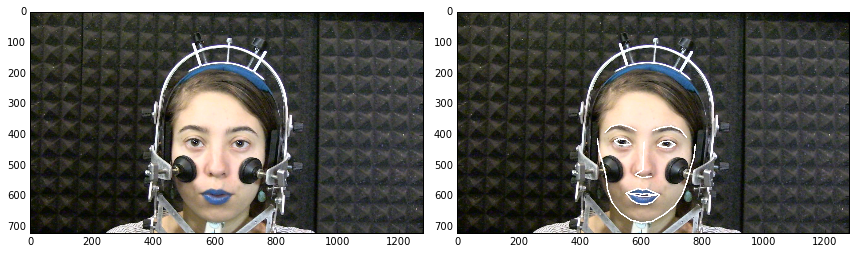

In [2]:
def landmark_plot_prep(target_dir,frame_idx):
    bmp = os.listdir(target_dir)[frame_idx] # get -70th file in dir and ...
    frame = cv2.imread(os.path.join(target_dir,bmp)) # read in as ndarray
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # change color map to RGB for display
    marks = iph.detect_landmarks(frame) # detect landmarks using imgphon
    return rgb, marks
    
rgb,marks = landmark_plot_prep('../40-lip-frames',-70) # get -70th frame for Subject 40 and...

# plot raw data on left; data annotated with detected facial landmarks on right
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.subplot(1,2,2)
plt.imshow(iph.draw_landmarks(rgb,marks,line_width=3))
plt.tight_layout()
plt.show()

All landmarks correspond reasonably well to their actual locations, even though we would expect the ultrasound stabilization helmet to interfere to some extent with this process (particularly the cheekpads, which can be erroneously detected as eyes; we will revisit this below).

Importantly, dlib detects a variety of lip shapes quite well and returns distinctly shaped mouth landmarks:

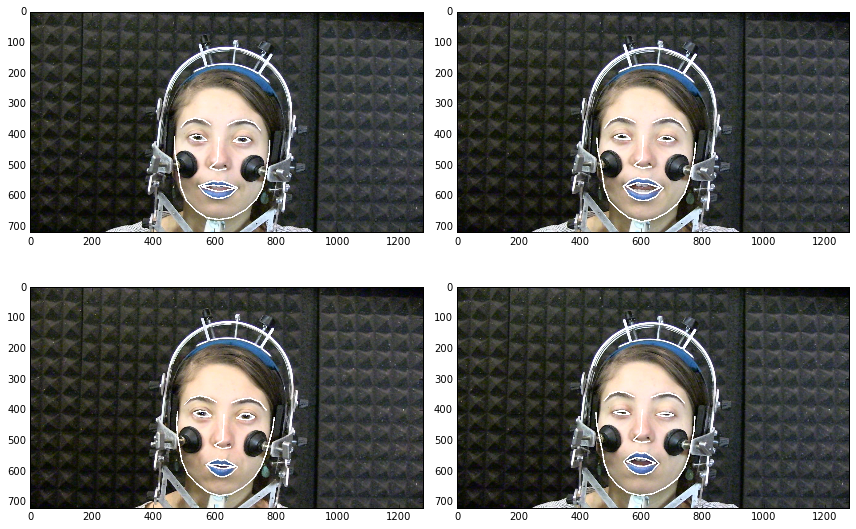

In [17]:
rgb1,marks1 = landmark_plot_prep('../40-lip-frames',0)
rgb2,marks2 = landmark_plot_prep('../40-lip-frames',6)
rgb3,marks3 = landmark_plot_prep('../40-lip-frames',-75)
rgb4,marks4 = landmark_plot_prep('../40-lip-frames',8)

plt.subplot(2,2,1)
plt.imshow(iph.draw_landmarks(rgb1,marks1,line_width=3))
plt.subplot(2,2,2)
plt.imshow(iph.draw_landmarks(rgb2,marks2,line_width=3))
plt.subplot(2,2,3)
plt.imshow(iph.draw_landmarks(rgb3,marks3,line_width=3))
plt.subplot(2,2,4)
plt.imshow(iph.draw_landmarks(rgb4,marks4,line_width=3))
plt.tight_layout()
plt.show() 

It is also trained on, and works on, a wide variety of faces (with facial hair, glasses, etc). Overall detection does not proceed quite as smoothly with this subject, since the jawline is partially obscured, but the lips are still reliably detected.

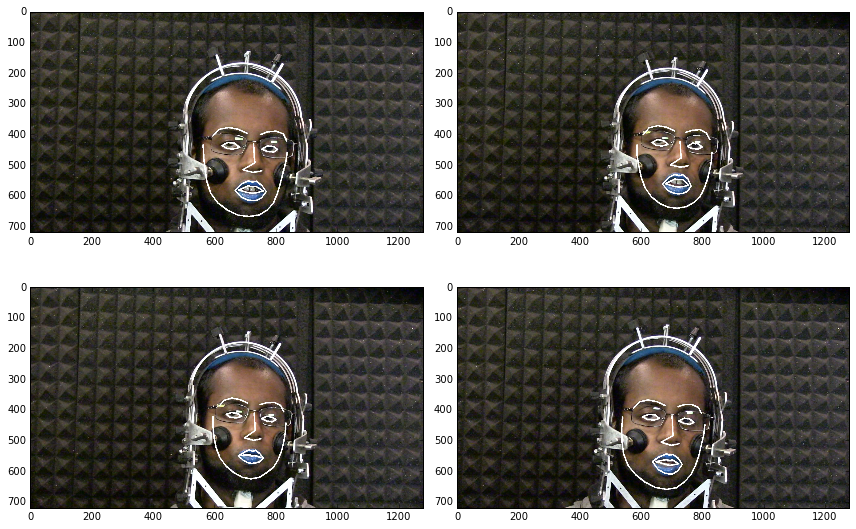

In [98]:
rgb1,marks1 = landmark_plot_prep('../32-lip-frames',17)
rgb2,marks2 = landmark_plot_prep('../32-lip-frames',9)
rgb3,marks3 = landmark_plot_prep('../32-lip-frames',11)
rgb4,marks4 = landmark_plot_prep('../32-lip-frames',-72)

# 13 is a problem frame to test out cheekpad removal on

plt.subplot(2,2,1)
plt.imshow(iph.draw_landmarks(rgb1,marks1,line_width=3))
plt.subplot(2,2,2)
plt.imshow(iph.draw_landmarks(rgb2,marks2,line_width=3))
plt.subplot(2,2,3)
plt.imshow(iph.draw_landmarks(rgb3,marks3,line_width=3))
plt.subplot(2,2,4)
plt.imshow(iph.draw_landmarks(rgb4,marks4,line_width=3))
plt.tight_layout()
plt.show() 

We could simply extract the lip shapes we get from data like the above and submit them to analysis, but subjects' heads are free to move throughout the experiment, resulting in changes in absolute location, overall size, and tilt of the lip shape that could be extracted from each frame. To improve on this situation, we normalize the angle and size of the entire face first, and then collect the lip data. 

As applied to both faces, we get the following. Note that the faces are scaled to the same relative size and orientation (in spite of the fact that the male subject was seated further away from the camera). The `FaceAligner` implemented in `imutils` and used in the `get_norm_face` function also happens to crop the image closer to the detected face.

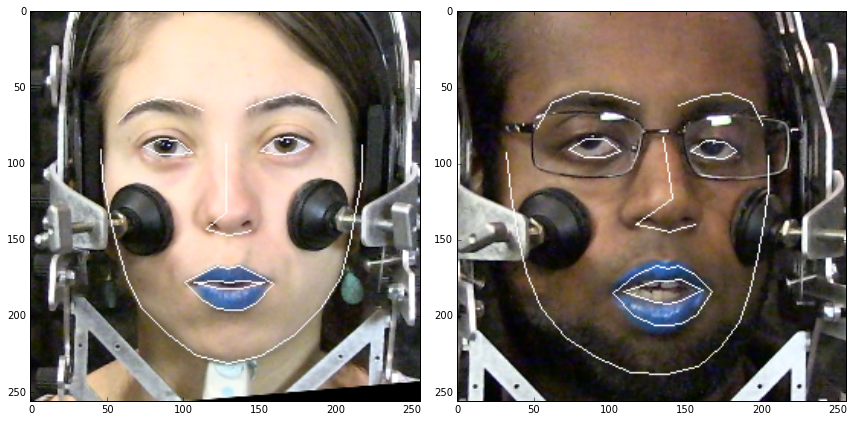

In [3]:
rgbF,marksF = landmark_plot_prep('../40-lip-frames',-75) # the female subject
alignF = iph.get_norm_face(rgbF)
align_marksF = iph.detect_landmarks(alignF)

rgbM,marksM = landmark_plot_prep('../32-lip-frames',-72) # the male subject
alignM = iph.get_norm_face(rgbM)
align_marksM = iph.detect_landmarks(alignM)

plt.subplot(1,2,1)
plt.imshow(iph.draw_landmarks(alignF,align_marksF,line_width=1))
plt.subplot(1,2,2)
plt.imshow(iph.draw_landmarks(alignM,align_marksM,line_width=1))
plt.tight_layout()
plt.show()

We can also isolate the lips and center them on a ground of consistent size. As applied to the data immediately above:

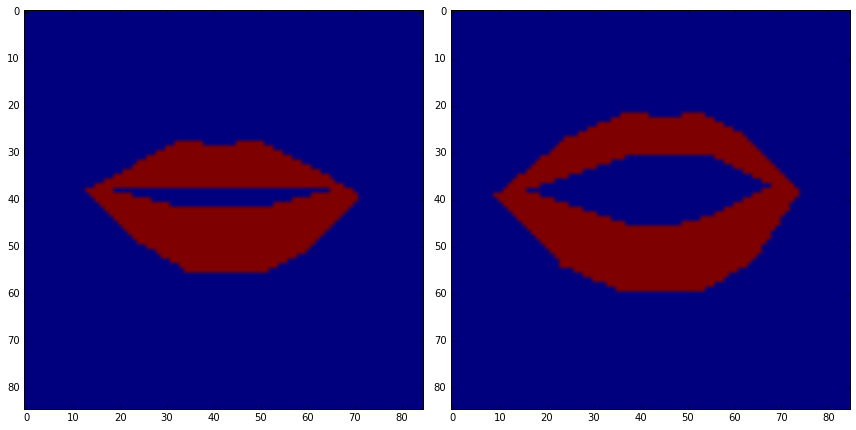

In [16]:
maskF = iph.lip_mask(alignF, align_marksF)
maskM = iph.lip_mask(alignM, align_marksM)

plt.subplot(1,2,1)
plt.imshow(crop_center(maskF))
plt.subplot(1,2,2)
plt.imshow(crop_center(maskM))
plt.tight_layout()
plt.show()

Collapsing all of the previous steps, we can get to this point for all of the data for each subject.

In [ ]:
# preallocate ndarray for a subj's lips?
### count up the number of files in the glob

# extract lips 
# normalize lips for rotation and relative size
# save to preallocated array

We can also view the lip polygons all at once.

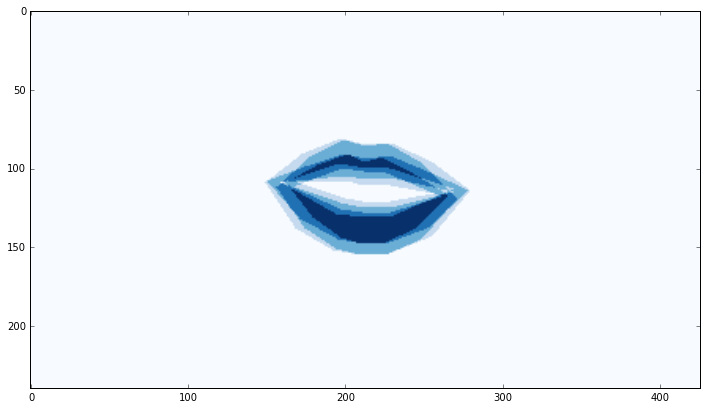

In [26]:
masks = [crop_center(iph.lip_mask(rgb1,marks1))]
masks.append(crop_center(iph.lip_mask(rgb2,marks2)))
masks.append(crop_center(iph.lip_mask(rgb3,marks3)))
masks.append(crop_center(iph.lip_mask(rgb4,marks4)))

plt.imshow(sum(masks),cmap='Blues') #rgb2,rgb3,rgb4

In [28]:
# align all of the faces and then do the below
align1 = iph.get_norm_face(rgb1)
align_marks1 = iph.detect_landmarks(align1)
align2 = iph.get_norm_face(rgb2)
align_marks2 = iph.detect_landmarks(align2)
align3 = iph.get_norm_face(rgb3)
align_marks3 = iph.detect_landmarks(align3)
align4 = iph.get_norm_face(rgb4)
align_marks4 = iph.detect_landmarks(align4)

masks = [crop_center(iph.lip_mask(align1,align_marks1))]
masks.append(crop_center(iph.lip_mask(align2,align_marks2)))
masks.append(crop_center(iph.lip_mask(align3,align_marks3)))
masks.append(crop_center(iph.lip_mask(align4,align_marks4)))

plt.imshow(sum(masks),cmap='Blues') #rgb2,rgb3,rgb4

In [30]:
target_dir = '../40-lip-frames'
bmp_glob = os.path.join(os.path.abspath(target_dir),"*.bmp")

masks = []
for bmp in glob.glob(bmp_glob):
    frame = cv2.imread(bmp) # read in as ndarray
    align = iph.get_norm_face(frame)
    marks = iph.detect_landmarks(align)
    mask = iph.lip_mask(align, marks)
    mask = crop_center(mask)
    masks.append(mask)

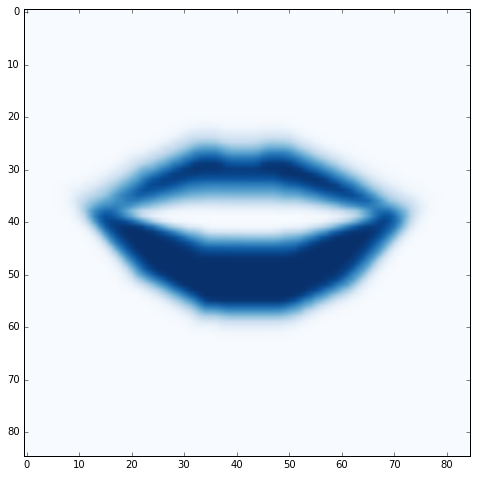

In [38]:
mu = np.mean(masks,axis=0)
plt.imshow(mu,cmap="Blues")

# Dimensionality reduction

Having assembled our data set, we find ourselves with (still) very high-dimensional data that is subjected to some noise. To clean up the data and reduce dimensionality, we undertake a principal components analysis (PCA) using utilities from `sklearn`. The cell below finds the first 20 principal components (PCs) that explain the most variation in the data we assembled above.

In [120]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

mask_array = np.stack(masks) # convert list of ndarrays to ndarray

mask_array_flat = mask_array.reshape([  # flatten the data so that it is one vector of 85*85 pixel values
        mask_array.shape[0],
        mask_array.shape[1] * mask_array.shape[2]
    ])

n_comp = 20
pca = PCA(n_components=n_comp) # run PCA
pca.fit(mask_array_flat)

PCA(copy=True, n_components=20, whiten=False)

We can visualize these components as the extent to which each pixel in the basis data varies as a part of that component. In the image below, extreme high values of the PCs are plotted in red, extreme low values are plotted in blue, and neutral values are in white.

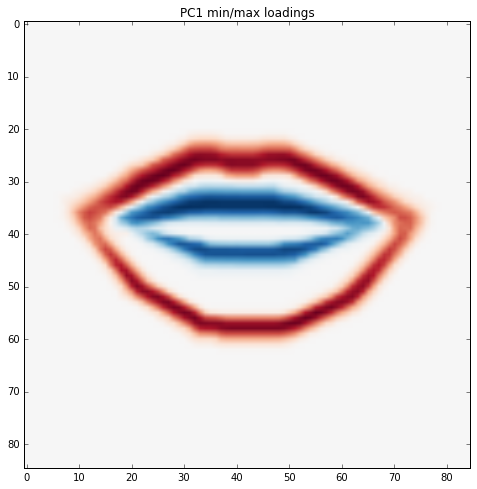

In [93]:
image_shape = (85,85) # define a shape to cast the data back into
pc = 1 # nth PC
dd = pca.components_[pc-1].reshape(image_shape) # get the n-1th PC from the list of PCs
mag = np.max(dd) - np.min(dd) # get magnitude of effect of PC by pixel
pc_load = (dd-np.min(dd))/mag*255 # scale to 0-255 range

# TODO add more panels to the plot
plt.title("PC{:} min/max loadings".format(pc))
plt.imshow(pc_load, cmap="RdBu") # red for low values, blue for high values

We can also explore the basis data using the PCs. We can, for instance, look for clustering in PC1-PC2 space.

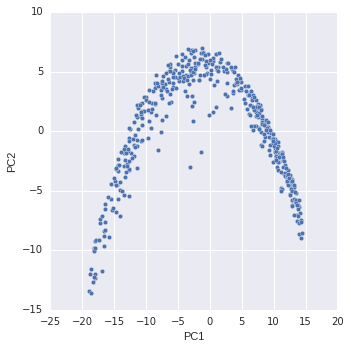

In [123]:
analysis = pca.transform(mask_array_flat) # characterize data as scaled combinations of PCs
df = pd.DataFrame(analysis) # convert to pandas DataFrame object
df.columns = ["PC{}".format(pc+1) for pc in range(n_comp)]
#df.plot.scatter('PC1','PC2',s=3)
sns.pairplot(x_vars=["PC1"], y_vars=["PC2"], data=df, size=5)

Of course, this is not terribly interesting without some information on linguistic categories. Adding some metadata on which English or French vowel is being produced, additional structure emerges:

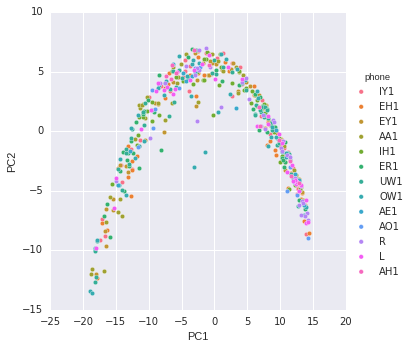

In [133]:
# TODO add in segment metadata
md = pd.read_csv('../40-lip-frames/40_vid_metadata.csv')
df = df.assign(phone=pd.Series(md['phone']).values)
sns.pairplot(x_vars=["PC1"], y_vars=["PC2"], data=df, hue="phone", size=5)

TODO explainer here

In [139]:
from sklearn.manifold import TSNE

n_tsne_comp = 2
X_embedded = TSNE(n_components=n_tsne_comp).fit_transform(analysis)

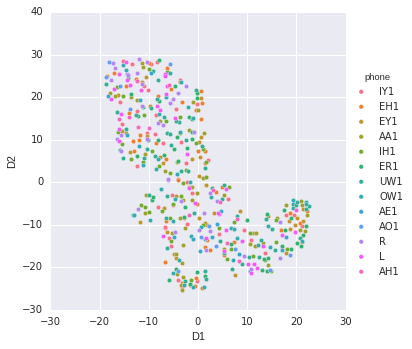

In [140]:
X_df = pd.DataFrame(X_embedded)
X_df.columns = ["D{}".format(d+1) for d in range(n_tsne_comp)]
X_df = X_df.assign(phone=pd.Series(md['phone']).values)
sns.pairplot(x_vars=["D1"], y_vars=["D2"], data=X_df, hue="phone", size=5)